In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import numpy as np
import cv2
import csv
from glob import glob
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from tqdm import tqdm
import random

# Check that you're using a recent OpenCV version.
assert cv2.__version__ > '4.5', 'Please use OpenCV 4.5 or later.'

Write down the plan in words and references. We will then fill in code.

In [2]:
# Encoding: ResNeXt (conv 1-3) => Position Enc. (ref. 2107.14222) => Deep-ViT (w/ EfficientNet)
# Decoding(for unsupervised training) : HiT(low resolution stage, same # as Deep-ViT) => FCC-GAN
# Comparison : Transformer-XL 
# Classifier/MLP : MLP head (output 8) => Reconstruction module => F

# Training Steps:
# 1. Train Encoder (unsupervised): manipulate input image (ref. SiT, + rotation) and match to output
# 2. Train Comparison (unsupervised) : use different head, mix&match the 2 images (ref. BERT, ALBERT)
# 3. Train MLP (supervised) : compare output to F

# Inference Steps: Encode each image => concat. 2 images => Comparison => MLP

#offical sample code: https://www.kaggle.com/code/eduardtrulls/imc2022-training-data?scriptVersionId=92062607

# Load data

In [3]:
# copied from sample code
# Input data files are available in the read-only "../input/" directory.

src = '../input/image-matching-challenge-2022/train'

val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "british_museum"" at ../input/image-matching-challenge-2022/train/british_museum
Found scene "piazza_san_marco"" at ../input/image-matching-challenge-2022/train/piazza_san_marco
Found scene "trevi_fountain"" at ../input/image-matching-challenge-2022/train/trevi_fountain
Found scene "st_pauls_cathedral"" at ../input/image-matching-challenge-2022/train/st_pauls_cathedral
Found scene "colosseum_exterior"" at ../input/image-matching-challenge-2022/train/colosseum_exterior
Found scene "buckingham_palace"" at ../input/image-matching-challenge-2022/train/buckingham_palace
Found scene "temple_nara_japan"" at ../input/image-matching-challenge-2022/train/temple_nara_japan
Found scene "sagrada_familia"" at ../input/image-matching-challenge-2022/train/sagrada_familia
Found scene "grand_place_brussels"" at ../input/image-matching-challenge-2022/train/grand_place_brussels
Found scene "pantheon_exterior"" at ../input/image-matching-challenge-2022/train/pantheon_exterior
Found scene "notre

Loaded 68 images.


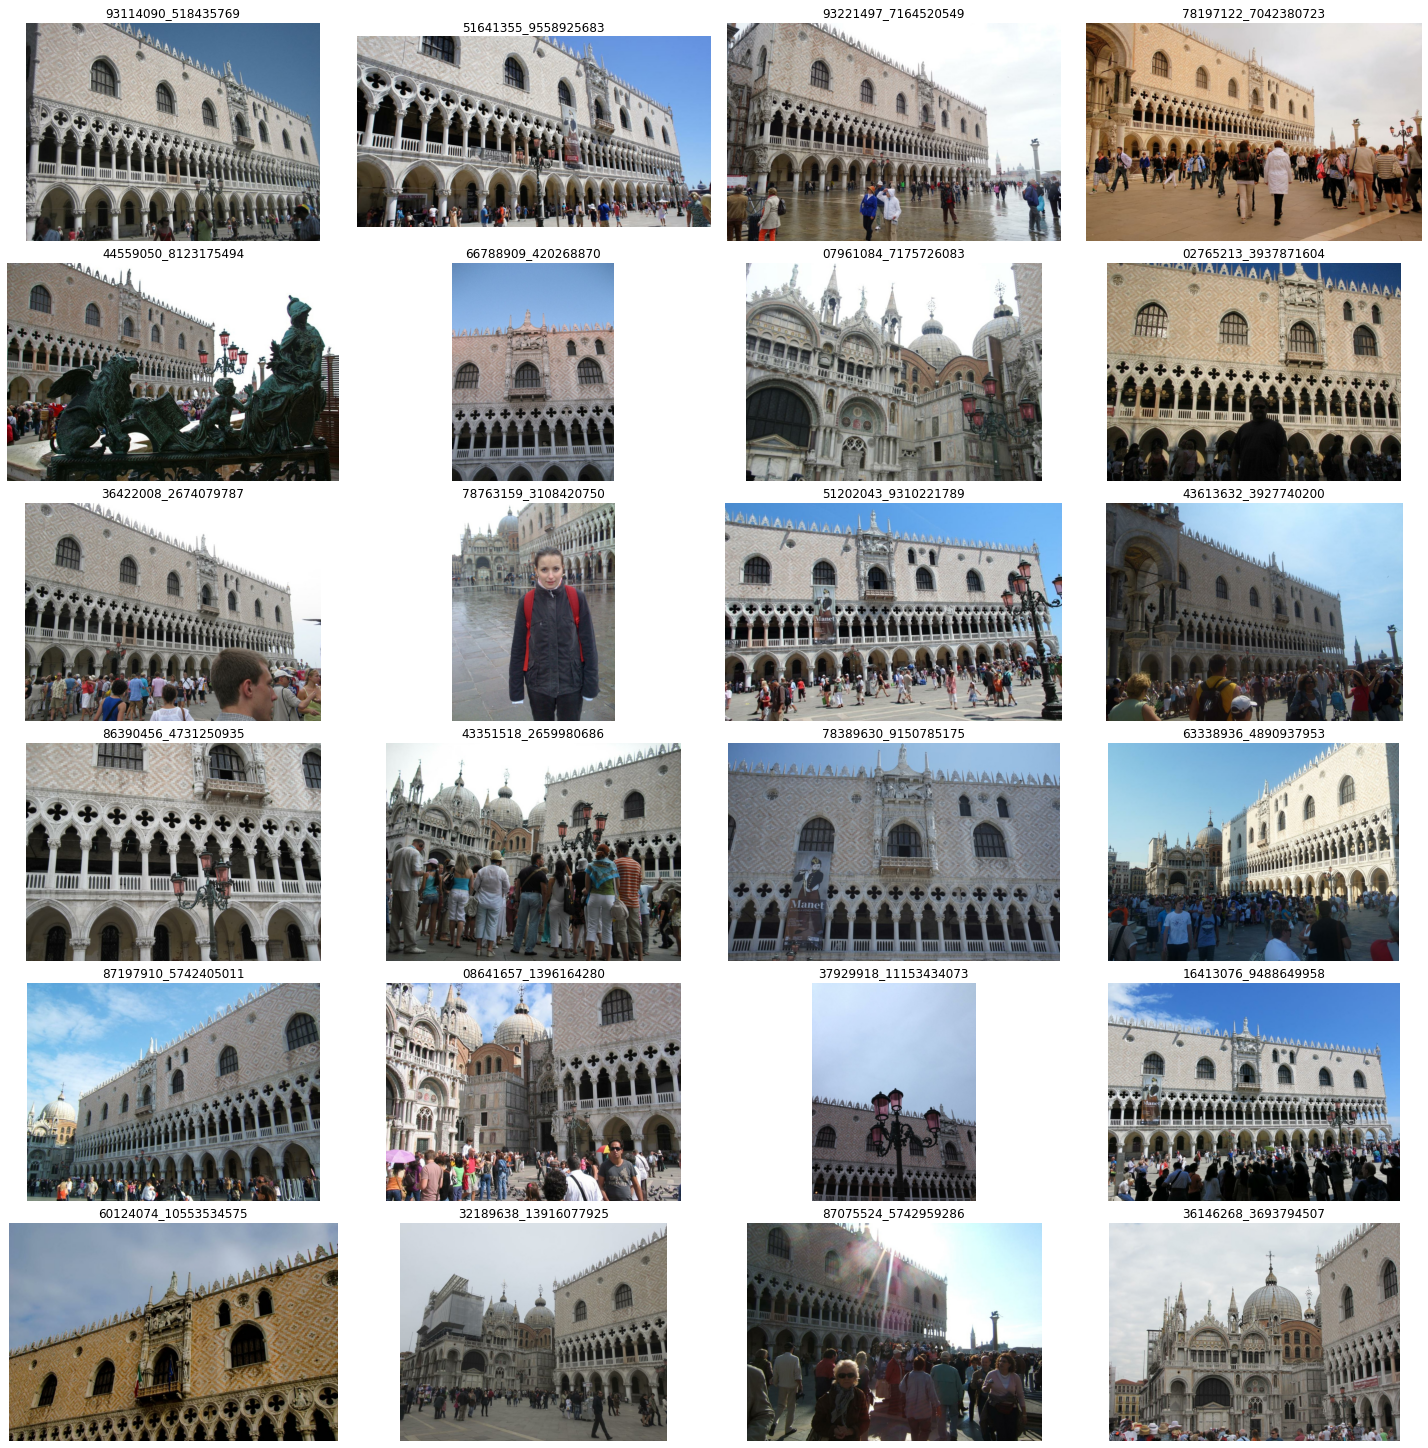

In [4]:
# Each scene in the validation set contains a list of images, poses, and pairs. Let's pick one and look at some images.

scene = 'piazza_san_marco'

images_dict = {}
for filename in glob(f'{src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])

    # OpenCV expects BGR, but the images are encoded in standard RGB, so you need to do color conversion if you use OpenCV for I/O.
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 6
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

In [5]:
# ResNeXt
# github: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# doc: https://pytorch.org/hub/pytorch_vision_resnext/
